# Tutorial 0. Introduction


## Create data based on some latent variables

see https://github.com/htwangtw/cca_primer/blob/master/cca_notebook.ipynb

In [91]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cross_decomposition import PLSCanonical, PLSRegression, CCA


In [77]:
n = 100
# fix the random seed so this tutorial will always create the same results
np.random.seed(42)
l1 = np.random.normal(size=n)
l2 = np.random.normal(size=n)

In [78]:
latents_x = np.array([l1, l2, l1, l1, l2, l2]).T
latents_y = np.array([l2, l2, l1, l1]).T

In [79]:
X = latents_x + np.random.normal(size=6 * n).reshape((n, 6))
Y = latents_y + np.random.normal(size=4 * n).reshape((n, 4))

In [80]:
X_train = X[:n // 2]
Y_train = Y[:n // 2]
X_test = X[n // 2:]
Y_test = Y[n // 2:]

Define plot function
(see https://scikit-learn.org/stable/auto_examples/cross_decomposition/plot_compare_cross_decomposition.html#sphx-glr-auto-examples-cross-decomposition-plot-compare-cross-decomposition-py)

In [81]:
def plot_scores(X_train_r, Y_train_r,
                X_test_r, Y_test_r):

    # 1) On diagonal plot X vs Y scores on each components
    plt.figure(figsize=(12, 8))
    plt.subplot(221)
    plt.scatter(X_train_r[:, 0], Y_train_r[:, 0], label="train",
                marker="o", c="b", s=25)
    plt.scatter(X_test_r[:, 0], Y_test_r[:, 0], label="test",
                marker="o", c="r", s=25)
    plt.xlabel("x scores")
    plt.ylabel("y scores")
    plt.title('Comp. 1: X vs Y (test corr = %.2f)' %
              np.corrcoef(X_test_r[:, 0], Y_test_r[:, 0])[0, 1])
    plt.xticks(())
    plt.yticks(())
    plt.legend(loc="best")

    plt.subplot(224)
    plt.scatter(X_train_r[:, 1], Y_train_r[:, 1], label="train",
                marker="o", c="b", s=25)
    plt.scatter(X_test_r[:, 1], Y_test_r[:, 1], label="test",
                marker="o", c="r", s=25)
    plt.xlabel("x scores")
    plt.ylabel("y scores")
    plt.title('Comp. 2: X vs Y (test corr = %.2f)' %
              np.corrcoef(X_test_r[:, 1], Y_test_r[:, 1])[0, 1])
    plt.xticks(())
    plt.yticks(())
    plt.legend(loc="best")

    # 2) Off diagonal plot components 1 vs 2 for X and Y
    plt.subplot(222)
    plt.scatter(X_train_r[:, 0], X_train_r[:, 1], label="train",
                marker="*", c="b", s=50)
    plt.scatter(X_test_r[:, 0], X_test_r[:, 1], label="test",
                marker="*", c="r", s=50)
    plt.xlabel("X comp. 1")
    plt.ylabel("X comp. 2")
    plt.title('X comp. 1 vs X comp. 2 (test corr = %.2f)'
              % np.corrcoef(X_test_r[:, 0], X_test_r[:, 1])[0, 1])
    plt.legend(loc="best")
    plt.xticks(())
    plt.yticks(())

    plt.subplot(223)
    plt.scatter(Y_train_r[:, 0], Y_train_r[:, 1], label="train",
                marker="*", c="b", s=50)
    plt.scatter(Y_test_r[:, 0], Y_test_r[:, 1], label="test",
                marker="*", c="r", s=50)
    plt.xlabel("Y comp. 1")
    plt.ylabel("Y comp. 2")
    plt.title('Y comp. 1 vs Y comp. 2 , (test corr = %.2f)'
              % np.corrcoef(Y_test_r[:, 0], Y_test_r[:, 1])[0, 1])
    plt.legend(loc="best")
    plt.xticks(())
    plt.yticks(())
    plt.show()

## CCA

Canonical Correlation Analysis was developed prior and independently to PLS. But it turns out that CCA is a special case of PLS, and corresponds to PLS in "Mode B" in the literature.

CCA can be unstable if the number of features or targets is greater than the number of samples.

See scikit-learn documentation for more informations. https://github.com/scikit-learn/scikit-learn/pull/17095/files?short_path=df97917#diff-df97917f68917d3a110df30940d771df

In [82]:
# CCA (PLS mode B with symmetric deflation)

cca = CCA(n_components=2)
cca.fit(X_train, Y_train)
X_train_r, Y_train_r = cca.transform(X_train, Y_train)
X_test_r, Y_test_r = cca.transform(X_test, Y_test)

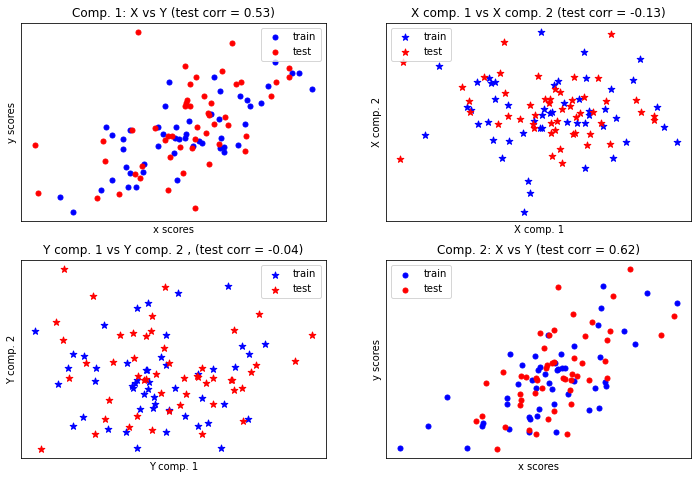

In [83]:
plot_scores(X_train_r, Y_train_r, X_test_r, Y_test_r)

## PLS Canonical

In [84]:
# Canonical (symmetric) PLS

plsca = PLSCanonical(n_components=2)
plsca.fit(X_train, Y_train)
X_train_r, Y_train_r = plsca.transform(X_train, Y_train)
X_test_r, Y_test_r = plsca.transform(X_test, Y_test)

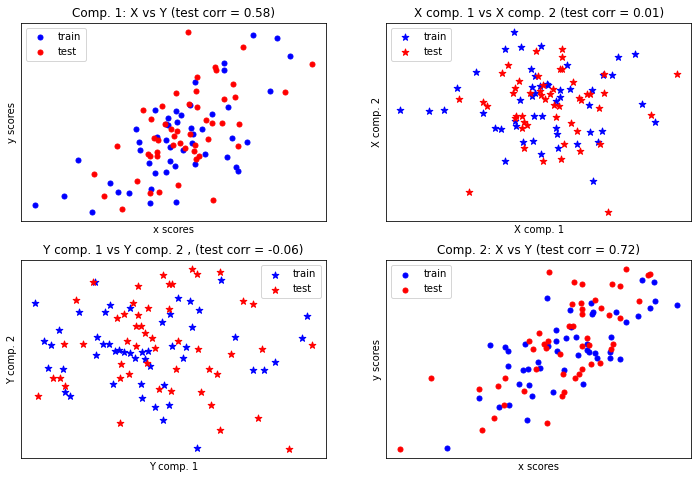

In [85]:
plot_scores(X_train_r, Y_train_r, X_test_r, Y_test_r)

## Overfitting

Link to tutorial 3 - model selection

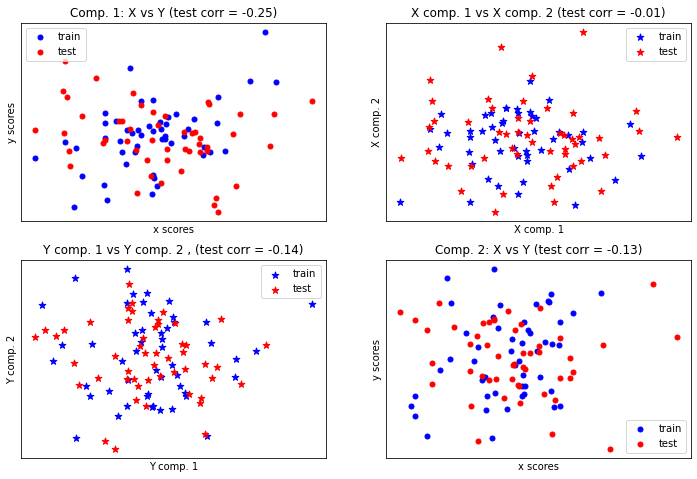

In [86]:
latents_x = np.array([l1, l1, l1, l1, l1, l1]).T
latents_y = np.array([l2, l2, l2, l2]).T

X = latents_x + np.random.normal(size=6 * n).reshape((n, 6))
Y = latents_y + np.random.normal(size=4 * n).reshape((n, 4))

X_train = X[:n // 2]
Y_train = Y[:n // 2]
X_test = X[n // 2:]
Y_test = Y[n // 2:]

cca = CCA(n_components=2)
cca.fit(X_train, Y_train)
X_train_r, Y_train_r = cca.transform(X_train, Y_train)
X_test_r, Y_test_r = cca.transform(X_test, Y_test)

plot_scores(X_train_r, Y_train_r, X_test_r, Y_test_r)

## PLS Regression

predict Y based on X (actually it is also possible with CCA and PLSCanonical, but maybe better in practice?)

In [89]:
# PLS regression, with multivariate response, a.k.a. PLS2

n = 1000
q = 3
p = 10
X = np.random.normal(size=n * p).reshape((n, p))
B = np.array([[1, 2] + [0] * (p - 2)] * q).T
# each Yj = 1*X1 + 2*X2 + noize
Y = np.dot(X, B) + np.random.normal(size=n * q).reshape((n, q)) + 5
Y.shape

(1000, 3)

In [90]:
pls2 = PLSRegression(n_components=3)
pls2.fit(X, Y)
print("True B (such that: Y = XB + Err)")
print(B)
# compare pls2.coef_ with B
print("Estimated B")
print(np.round(pls2.coef_, 1))
pls2.predict(X)

True B (such that: Y = XB + Err)
[[1 1 1]
 [2 2 2]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]]
Estimated B
[[ 1.1  1.1  1.1]
 [ 2.   2.1  2.1]
 [ 0.  -0.   0. ]
 [ 0.   0.  -0. ]
 [-0.   0.  -0. ]
 [-0.1  0.   0. ]
 [ 0.  -0.  -0. ]
 [ 0.  -0.   0. ]
 [-0.1  0.1  0. ]
 [-0.  -0.   0. ]]


array([[5.26894782, 5.76958399, 5.61424268],
       [3.60819779, 3.82434619, 3.6054785 ],
       [3.9072444 , 3.87712116, 3.68853234],
       ...,
       [7.57274173, 7.80051476, 7.8226507 ],
       [5.15137191, 5.14623703, 5.09687754],
       [3.38848344, 3.45290944, 3.46096899]])

In [62]:
# PLS regression, with univariate response, a.k.a. PLS1

n = 1000
p = 10
X = np.random.normal(size=n * p).reshape((n, p))
y = X[:, 0] + 2 * X[:, 1] + np.random.normal(size=n * 1) + 5
pls1 = PLSRegression(n_components=3)
pls1.fit(X, y)
# note that the number of components exceeds 1 (the dimension of y)
print("Estimated betas")
print(np.round(pls1.coef_, 1))

Estimated betas
[[ 1.1]
 [ 2. ]
 [ 0. ]
 [-0. ]
 [ 0. ]
 [-0. ]
 [-0. ]
 [ 0.1]
 [ 0. ]
 [-0. ]]


## PLS-PM

PLSPM allows to deal with more than 1 block of data
But no more than one mode computed

In [66]:
import pandas as pd, plspm.config as c
from plspm.plspm import Plspm
from plspm.scheme import Scheme
from plspm.mode import Mode

# create dataset
l1 = np.random.normal(size=n)
l2 = np.random.normal(size=n)
l3 = np.random.normal(size=n)

latents_x = np.array([l1, l1, l1, l2, l2, l2]).T
latents_y = np.array([l2, l2, l2, l2]).T
latents_z = np.array([l3, l3, l3, l3, l3]).T
latents_c = np.array([l1, l1, l2]).T

X = latents_x + np.random.normal(size=6 * n).reshape((n, 6))
Y = latents_y + np.random.normal(size=4 * n).reshape((n, 4))
Z = latents_z + np.random.normal(size=5 * n).reshape((n, 5))
C = latents_c + np.random.normal(size=3 * n).reshape((n, 3))

df = pd.DataFrame(np.concatenate([X, Y, Z, C], axis=1),
                  columns=[f'x{i}' for i in range(X.shape[1])] + \
                          [f'y{i}' for i in range(Y.shape[1])] + \
                          [f'z{i}' for i in range(Z.shape[1])] + \
                          [f'c{i}' for i in range(C.shape[1])])


In [67]:
lvs = ["X", "Y", "Z", "C"]
sat_path_matrix = pd.DataFrame(
    [[0, 0, 0, 0],
     [0, 0, 0, 0],
     [0, 0, 0, 0],
     [1, 1, 1, 0]],
    index=lvs, columns=lvs)
config = c.Config(sat_path_matrix, scaled=False)
config.add_lv_with_columns_named("X", Mode.A, df, "x")
config.add_lv_with_columns_named("Y", Mode.A, df, "y")
config.add_lv_with_columns_named("Z", Mode.A, df, "z")
config.add_lv_with_columns_named("C", Mode.A, df, "c")
plspm_calc = Plspm(df, config, Scheme.CENTROID)

TypeError: dot() got an unexpected keyword argument 'index'

In [43]:
print(plspm_calc.inner_summary())

         type  r_squared  block_communality  mean_redundancy       ave
C  Endogenous     0.4468           0.355615         0.158889  0.355615
X   Exogenous     0.0000           0.339051         0.000000  0.339051
Y   Exogenous     0.0000           0.627290         0.000000  0.627290
Z   Exogenous     0.0000           0.528761         0.000000  0.528761


In [44]:
print(plspm_calc.path_coefficients())

          X         Y         Z  C
X  0.000000  0.000000  0.000000  0
Y  0.000000  0.000000  0.000000  0
Z  0.000000  0.000000  0.000000  0
C  0.434067  0.288953 -0.002108  0


In [65]:
plspm_calc = Plspm(df, config, Scheme.CENTROID,
                   bootstrap=True, bootstrap_iterations=10)

TypeError: dot() got an unexpected keyword argument 'index'

In [47]:
print(plspm_calc.bootstrap().paths())

        original      mean  std.error  perc.025  perc.975
X -> C  0.367826  0.491835   0.090739  0.320404  0.619434
Y -> C  0.382045  0.245976   0.080965  0.139079  0.395896
Z -> C -0.033912 -0.021446   0.027471 -0.064982  0.042405


In [48]:
print(plspm_calc.bootstrap().loading())

    original      mean  std.error  perc.025  perc.975
x0  0.369496  0.479086   0.152313  0.187114  0.680786
x1  0.380977  0.489789   0.155564  0.201542  0.714830
x2  0.279247  0.396984   0.167148  0.075650  0.643569
x3  0.756284  0.675663   0.102023  0.490539  0.830921
x4  0.718441  0.629045   0.120409  0.380080  0.792220
x5  0.765855  0.680214   0.109639  0.450731  0.829466
y0  0.756624  0.755237   0.020741  0.720029  0.793686
y1  0.798814  0.796745   0.015081  0.768422  0.824341
y2  0.806833  0.803322   0.015335  0.777838  0.832883
y3  0.804733  0.808407   0.014206  0.783912  0.835043
z0  0.900614  0.800147   0.123492  0.502912  0.924676
z1  0.593241  0.601454   0.155528  0.182086  0.814805
z2  0.620051  0.630822   0.146560  0.252221  0.832072
z3  0.758269  0.709184   0.135431  0.371086  0.900090
z4  0.722029  0.705912   0.132811  0.430455  0.893429
c0  0.362141  0.467167   0.150369  0.195333  0.697990
c1  0.334643  0.439051   0.154476  0.165424  0.685149
c2  0.907586  0.824486   0.1